# 1D Demo LGRT for GPs

### Import packages

In [1]:
!pip install lgrt4gps
import os
import numpy as np
import pandas as pd
from time import time
import urllib.request
from scipy.io import loadmat
from scipy.stats import norm
import matplotlib.pyplot as plt
from lgrt4gps.lgrtn import LGRTN

### Load data set

In [2]:
infile = "sarcos_inv_train.mat"
if not os.path.exists(infile):
    print("Downloading Sarcos training data...")
    urllib.request.urlretrieve(
            "http://www.gaussianprocess.org/gpml/data/sarcos_inv.mat", infile)
data_tr = loadmat(infile)['sarcos_inv'].astype(np.float32)
xtr, ytr = data_tr[:,:21], data_tr[:,21:22]

infile = "sarcos_inv_test.mat"
if not os.path.exists(infile):
    print("Downloading Sarcos test data...")
    urllib.request.urlretrieve(
        "http://www.gaussianprocess.org/gpml/data/sarcos_inv_test.mat", infile)
data_te = loadmat(infile)['sarcos_inv_test'].astype(np.float32)
xte, yte = data_te[:,:21], data_te[:,21:22]

ntr, dx = xtr.shape
nte, dy = yte.shape


print('Read ' + str(ntr) + ' training and ' + str(nte) + ' tests data points')
print('Input dimension: ' + str(dx) + ', Output dimension: ' + str(dy))

Read 44484 training and 4449 tests data points
Input dimension: 21, Output dimension: 1


### Run over different sizes of data sets (takes upto 1min, result is save to file)

In [3]:
labels = ['N','t_train', 't_pred','t_add',
        'tree_height', 'num_leaves',
        'mse','nll']
results = []

ntr = xtr.shape[0]
for n in range(1,ntr,1000):
    lgrt_gp = LGRTN(dx, dy)
    idx = np.random.choice(ntr, n, replace=False)
    idx1 = np.random.choice(ntr, 1, replace=False)
    t1 = time()
    lgrt_gp.add_data(xtr[idx,:], ytr[idx,:])
    t2 = time()
    mu, sig = lgrt_gp.predict(xte, return_std=True)
    t3 = time()
    lgrt_gp.add_data(xtr[idx1, :], ytr[idx1, :])
    t4 = time()

    results.append([n, t2-t1, (t3-t2)/xte.shape[0], t4-t3,
                        lgrt_gp.height, lgrt_gp.leaf_count,
                        np.mean((mu - yte) ** 2),
                        -np.sum(norm.logpdf(yte,loc=mu, scale=sig)) ])

    df = pd.DataFrame(results, columns=labels)
    df.to_csv('results_sarcos.csv')  

### Load and plot results loaded from file

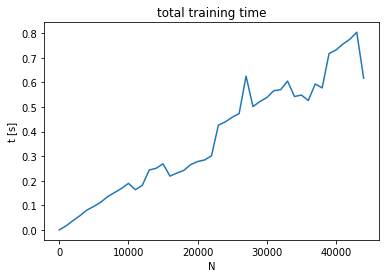

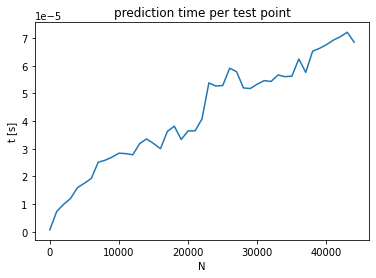

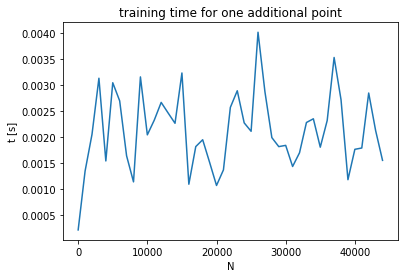

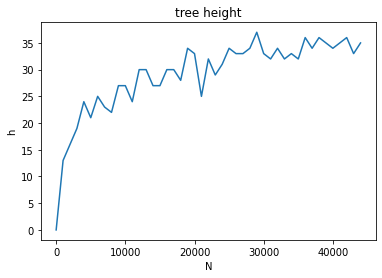

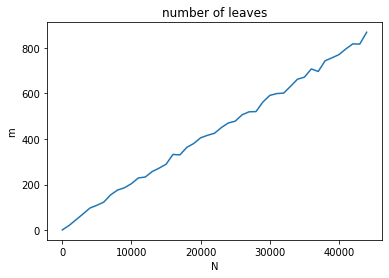

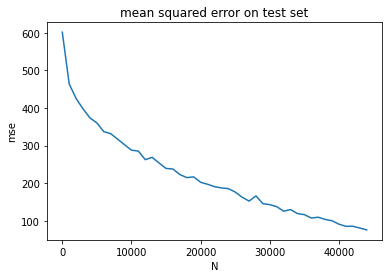

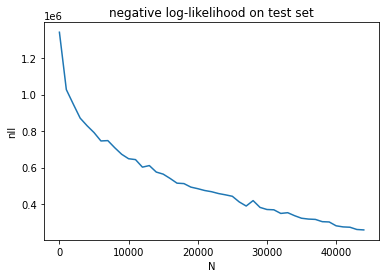

In [29]:
pd.read_csv('results_sarcos.csv')
titles = ['total training time', 
           'prediction time per test point', 
           'training time for one additional point', 
          'tree height',
          'number of leaves',
          'mean squared error on test set', 
          'negative log-likelihood on test set']
ylabels = ['t [s]', 't [s]', 't [s]','h','m','mse','nll']

cols = df.columns[1:]
for t, c, yl in zip(titles, cols, ylabels):
    fig = plt.figure()
    plt.title(t)
    ax = plt.plot(df['N'],df[c])
    plt.xlabel('N')
    plt.ylabel(yl)

